In [37]:
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.dates as mdates
from mpl_finance import candlestick_ohlc
import pandas as pd
import pandas_datareader.data as web

#Loading data
company='AAPL'

plt.rcParams['figure.figsize'] = [20, 10]
start= dt.datetime(2000,1,1)
end=dt.datetime(2019,12,31)

df = web.DataReader(company,'yahoo',start,end)
df.to_csv(company+'.csv')


In [28]:
pd.read_csv(company+'.csv',parse_dates=True,index_col=0)
df.head()


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2000-01-03,4.017857,3.631696,3.745536,3.997768,133949200.0,2.655498
2000-01-04,3.950893,3.613839,3.866071,3.660714,128094400.0,2.431611
2000-01-05,3.948661,3.678571,3.705357,3.714286,194580400.0,2.467196
2000-01-06,3.821429,3.392857,3.790179,3.392857,191993200.0,2.253689
2000-01-07,3.607143,3.410714,3.446429,3.553571,115183600.0,2.360442


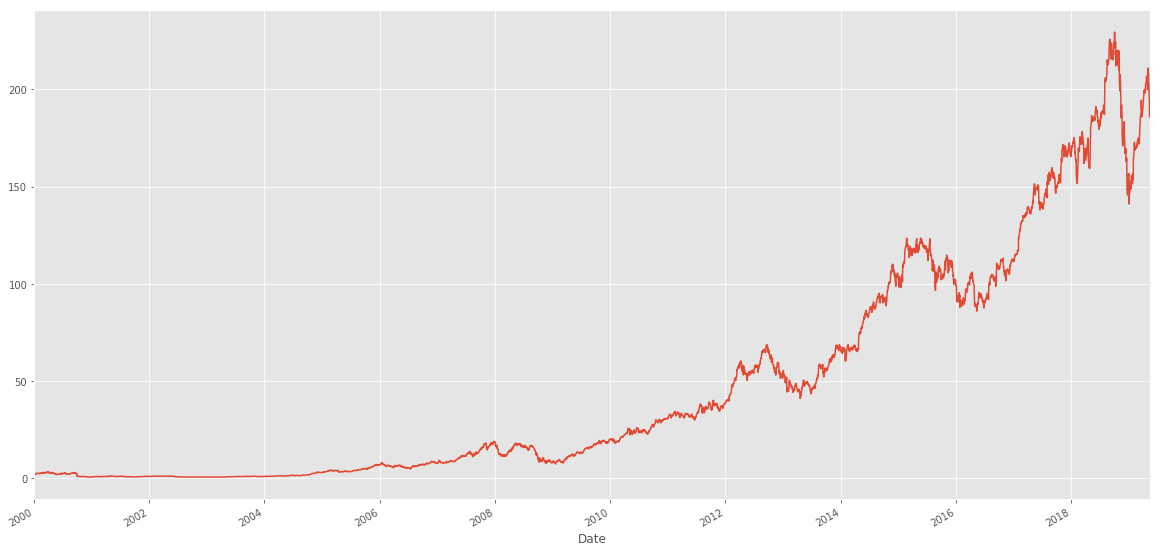

In [29]:
style.use('ggplot')
df['Adj Close'].plot()
plt.show()


<BarContainer object of 4874 artists>

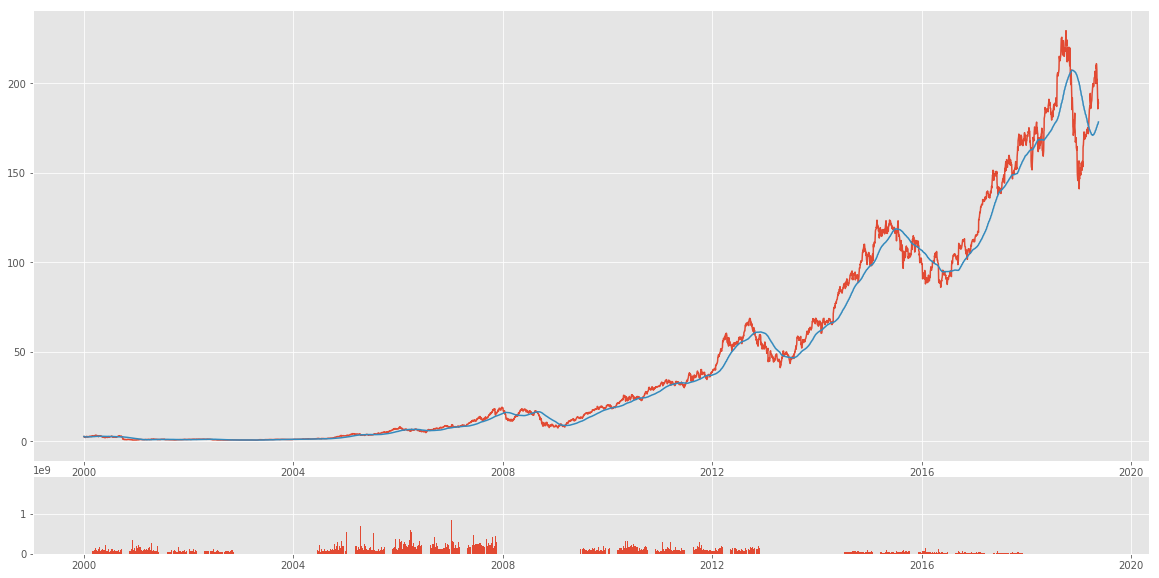

In [30]:
df_copy=df.copy()
df_copy['100ma'] = df['Adj Close'].rolling(window=100,min_periods=0).mean()
ax1=plt.subplot2grid((6,1),(0,0),rowspan=5,colspan=1)
ax2=plt.subplot2grid((6,1),(5,0),rowspan=1,colspan=1,sharex=ax1)
ax1.plot(df.index,df['Adj Close'])
ax1.plot(df_copy.index,df_copy['100ma'])
ax2.bar(df.index,df['Volume'])



In [32]:
(df_copy.head())

,High,Low,Open,Close,Volume,Adj Close,100ma
Date,,,,,,,
2000-01-03,4.017857,3.631696,3.745536,3.997768,133949200.0,2.655498,2.655498
2000-01-04,3.950893,3.613839,3.866071,3.660714,128094400.0,2.431611,2.543554
2000-01-05,3.948661,3.678571,3.705357,3.714286,194580400.0,2.467196,2.518101
2000-01-06,3.821429,3.392857,3.790179,3.392857,191993200.0,2.253689,2.451998
2000-01-07,3.607143,3.410714,3.446429,3.553571,115183600.0,2.360442,2.433687


In [33]:
df_ohlc=df['Adj Close'].resample('10D').ohlc()
df_volume=df['Volume'].resample('10D').sum()

df_ohlc.reset_index(inplace=True)
df_ohlc['Date']=df_ohlc['Date'].map(mdates.date2num)
print(df_ohlc.head())

       Date      open      high       low     close
0  730122.0  2.655498  2.655498  2.068352  2.068352
1  730132.0  2.295204  2.692565  2.295204  2.640671
2  730142.0  2.520573  2.662911  2.378235  2.378235
3  730152.0  2.344133  2.725184  2.344133  2.579880
4  730162.0  2.747424  2.823041  2.639188  2.639188


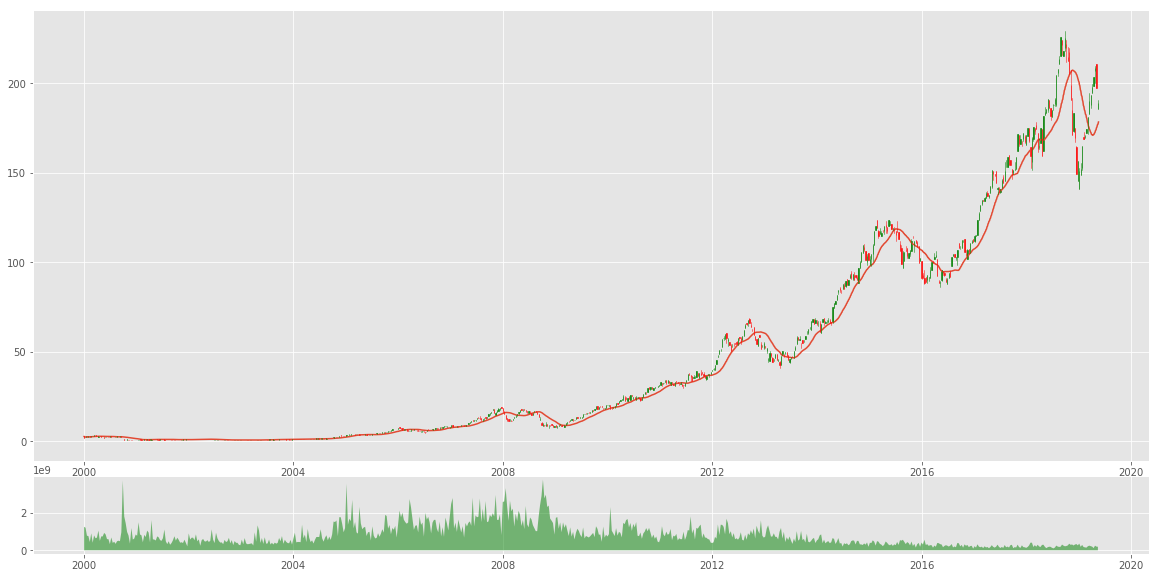

In [34]:
ax1=plt.subplot2grid((6,1),(0,0),rowspan=5,colspan=1)
ax2=plt.subplot2grid((6,1),(5,0),rowspan=1,colspan=1,sharex=ax1)
ax1.xaxis_date()
ax1.plot(df_copy.index,df_copy['100ma'])
candlestick_ohlc(ax1, df_ohlc.values,width=2,colorup='g')
ax2.fill_between(df_volume.index.map(mdates.date2num),df_volume.values,0,facecolor='green', alpha=0.5)
plt.show()



In [67]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
import os
import matplotlib.pyplot as plt
def create_dataset(ticker, daysPrediction=50,splitProportion=0.8):
    #Read data
    df = pd.read_csv('sp500_closes.csv')
    tickers = df.columns.values.tolist()

    #Get Adj Close values of ticker and convert it to numpy array
    values = df[ticker].values
    values=values.reshape(-1,1)

    #Split the dataset in the training set and test set
    dataset_train = np.array(values[:int(values.shape[0] * splitProportion)])
    dataset_test = np.array(values[int(values.shape[0] * splitProportion) - daysPrediction:])

    #Normalize dataset in range [0-1]
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset_train = scaler.fit_transform(dataset_train)
    dataset_test = scaler.transform(dataset_test)

    #Create the X and Y variables of the dataset in a format numpy array
    x_train, y_train = create_d_dataset(dataset_train,daysPrediction)
    x_test, y_test = create_d_dataset(dataset_test,daysPrediction)

    #Prepare data for the neural network
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    #Return dataset and other data
    return x_test,y_test,x_train,y_train,df,ticker,scaler,values

def create_d_dataset(val,daysPrediction):

    x = []
    y = []
    for i in range(daysPrediction, val.shape[0]):
        x.append(val[i-daysPrediction:i, 0])
        y.append(val[i, 0])
    x = np.array(x)
    y = np.array(y)

    return x,y


def train(train_x,train_y,ticker):
    #Create LSTM RNN model
 
    model = Sequential()
   
    model.add(LSTM(units=96, return_sequences=True, input_shape=(train_x.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=96, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=96, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=96))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(loss='mean_squared_error', optimizer='adam')
  
    #Train network and save it
    if (not os.path.exists(f'stock_prediction-{ticker}.h5')):
        model.fit(train_x, train_y, epochs=3, batch_size=32)
        model.save(f'stock_prediction-{ticker}.h5')

def show_results(test_x,test_y,train_y,ticker,scaler,values,df):
    #Load the trained neural network
    model = load_model(f'stock_prediction-{ticker}.h5')

    #Use the network to to predict the test dataset
    predictions = model.predict(test_x)
    predictions = scaler.inverse_transform(predictions)
    

    #Graphically see the prediction of the neural network
    fig, ax = plt.subplots(figsize=(20, 10))
   
    y_test_scaled = scaler.inverse_transform(test_y.reshape(-1, 1))
    ax.plot(y_test_scaled, color=(0, 0, 0.7, 0.5), label="True Price")
    plt.plot(predictions, color=(0, 0.7, 0,0.5),
            label='Predicted Testing Price')
    plt.legend()
    
    #Temporal
    fig, ax2 = plt.subplots(figsize=(20, 10))
    plt.plot(df[ticker].values, color=(0, 0, 0.7, 0.5), label="True Price")
    ax2.plot(range(len(train_y) + 50, len(train_y) + 50 + len(predictions)), predictions, color=(0, 0.7, 0,0.5),
             label='Predicted Testing Price')
    plt.legend()

def predictFuture(ticker):
    #Create the dataset with the given ticker
    x_test,y_test,x_train,y_train,df,ticker,scaler,values=create_dataset(ticker)

    #Train the RNN network
    train(x_train,y_train,ticker=ticker)

    #Show results of the training
    show_results(x_test,y_test, y_train,ticker,scaler,values,df)


In [47]:
closes = pd.read_csv('sp500_closes.csv')
(closes.head())


,Date,MMM,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,...,WLTW,WYNN,XEL,XRX,XLNX,XYL,YUM,ZBH,ZION,ZTS
0,2000-01-03,27.292488,6.671639,NaN,18.25000,NaN,1.235628,16.145748,15.500,NaN,...,NaN,NaN,7.994064,53.765923,33.829617,NaN,4.457160,NaN,42.207615,NaN
1,2000-01-04,26.208023,6.481020,NaN,17.81250,NaN,1.198042,14.791295,14.625,NaN,...,NaN,NaN,8.178138,51.265186,33.060757,NaN,4.367568,NaN,40.163754,NaN
2,2000-01-05,26.967150,6.469106,NaN,18.00000,NaN,1.202740,15.083735,15.000,NaN,...,NaN,NaN,8.493693,53.904873,32.337139,NaN,4.389968,NaN,40.116234,NaN
3,2000-01-06,29.136089,6.695467,NaN,18.03125,NaN,1.179249,15.206868,16.000,NaN,...,NaN,NaN,8.414804,52.793427,29.533081,NaN,4.352638,NaN,40.686600,NaN
4,2000-01-07,29.714483,6.766949,NaN,17.93750,NaN,1.212137,15.945663,16.250,NaN,...,NaN,NaN,8.414804,54.043797,32.879860,NaN,4.255581,NaN,40.781673,NaN


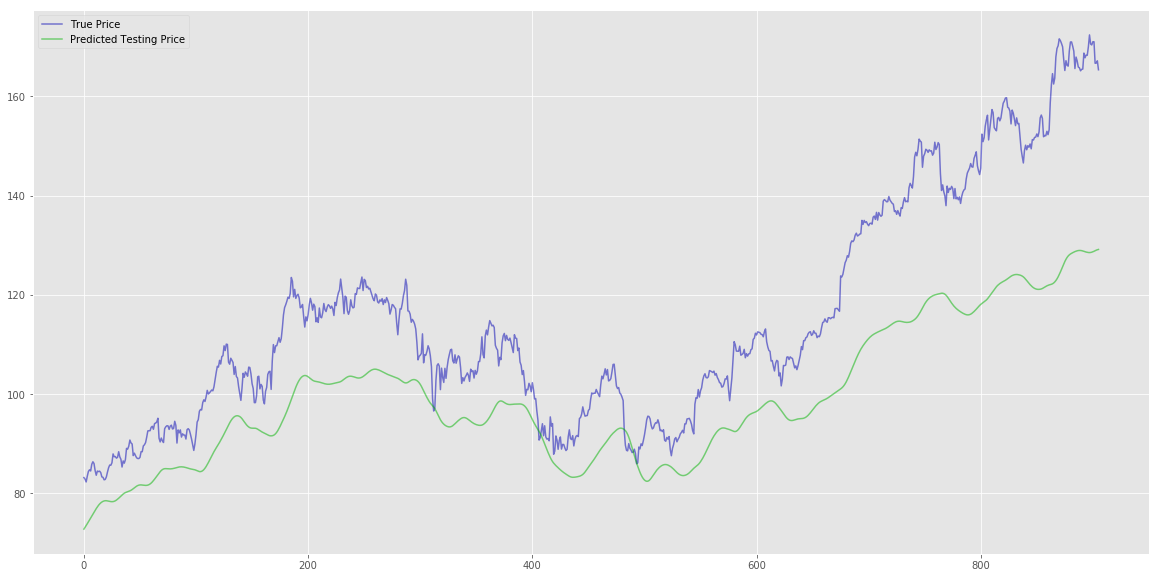

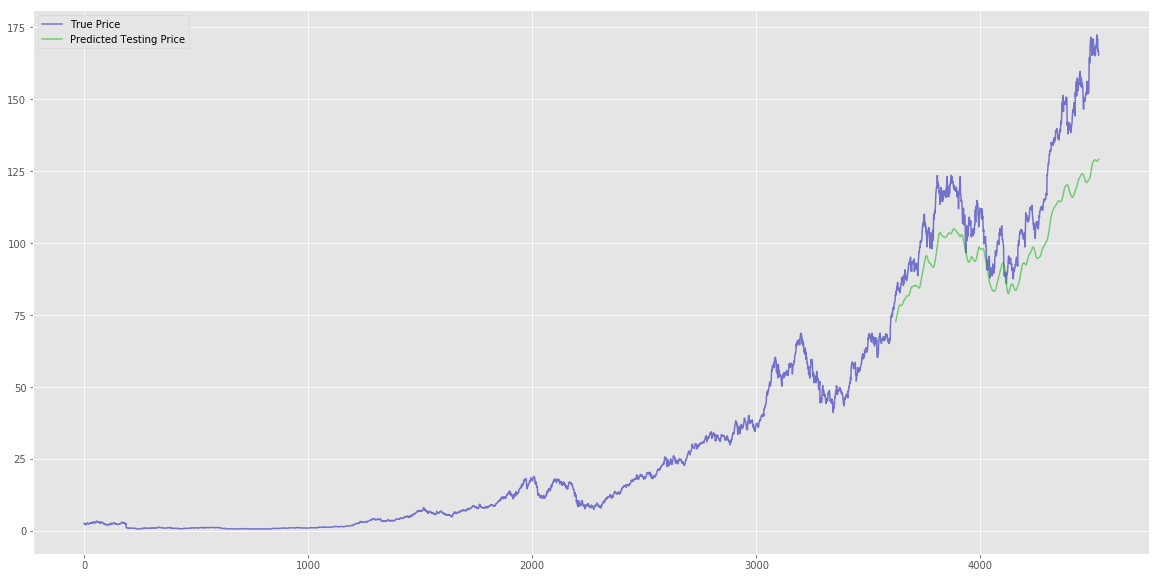

In [68]:
predictFuture(company)
